# CIFAR-10 classification
## 1. Baseline
### 1.1.  import libraries and define hyperparameters

In [ ]:
!pip -q install cleverhans
!pip -q install linformer
!pip -q install ptflops
!pip -q install vit_pytorch

     |████████████████████████████████| 327kB 3.0MB/s 
     |████████████████████████████████| 163kB 14.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 


In [13]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)
from linformer import Linformer
import matplotlib.pyplot as plt 
import numpy as np
import os 
from ptflops import get_model_complexity_info
import random
import torch
from torch import nn
from torchvision.models import resnet34, resnet101, mobilenet_v2
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT

In [14]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
seed_everything(seed)

In [15]:
device = 'cuda'

In [19]:
batch_size = 64
epochs = 5
lr = 3e-5
gamma = 0.7

### 1.2. load and normalize CIFAR-10

In [20]:
transform_train = transforms.Compose([
    torchvision.transforms.RandomCrop(4),
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomRotation(15)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [21]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainset, valset = torch.utils.data.random_split(dataset, [45000, 5000])
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 1.3. define a transformer

In [22]:
class ResNetFeatures(nn.Module):
    '''
    ResNetFeatures outputs the lower level features from pretrained ResNet34 till the intial 5 layers 
    (conv1, bn1, relu, maxpool, layer1(3 conv layers)) to be used in the hybrid architecture to be 
    able to kickstart the learining faster. The sequence of operations is as follows :-

    Input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> Output

    Args:
        No arguments required
    
    Methods:
        forward(inp) :-
        Applies the sequence of operations mentioned above.
        (batch_size, 3, 224, 224) -> (batch_size, 64, 56, 56)
    
    Examples:
        >>> resnet_features = ResNetFeatures()
        >>> out = resnet_features(inp)
    '''
    def __init__(self):
        super(ResNetFeatures, self).__init__()
        layers = list(resnet34(pretrained=True).children())[:5] #all layer expect last layer
        self.feature_extractor = nn.Sequential(*layers)
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

class HybridViT(nn.Module):
    def __init__(self, image_size=32, patch_size=4, num_classes=10, dim=128, depth=10, channels=3, heads=8, k=64 ):
        super(HybridViT,self).__init__()
        self.ResNetFeatures = ResNetFeatures()
        self.image_size = image_size // 4
        self.patch_size = self.image_size // (image_size // patch_size)
        self.channels=64
        efficient_transformer = Linformer(
            dim=dim,
            seq_len=(image_size//patch_size)**2+1,
            depth=depth,
            heads=heads,
            k=k
        )
        self.ViT = ViT(
            dim=128,
            image_size=self.image_size,
            patch_size=self.patch_size,
            num_classes=num_classes,
            transformer=efficient_transformer,
            channels=self.channels,
        )
        
    def forward(self, img):
        x = self.ResNetFeatures(img)
        x = self.ViT(x)
        return x

model = HybridViT(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=128,
    depth=10,
    channels=3,
    heads=8,
    k=64
).to(device)

Let's see the parameter numbers and FLOPs of Hybrid ViT

In [23]:
macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.15 GMac
Number of parameters:           2.31 M  


### 1.4. Let's start our training!

In [24]:
# loss function
criterion = torch.nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=gamma)

In [25]:
loss_record = {'train': [], 'validation': []} 
acc_record = {'train': [], 'validation': []} 

In [26]:
def train(epochs, model, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer, adv_train=False):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        print("current lr = %lf"%optimizer.param_groups[0]['lr'])

        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)
            if adv_train:
                # Replace clean example with adversarial example for adversarial training
                data = projected_gradient_descent(model, data, 0.3, 0.01, 40, np.inf)
            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        loss_record['train'].append(epoch_loss.detach().cpu().item())
        acc_record['train'].append(epoch_accuracy.detach().cpu().item())
        
        #scheduler.step()

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
            loss_record['validation'].append(epoch_val_loss.detach().cpu().item())
            acc_record['validation'].append(epoch_val_accuracy.detach().cpu().item())

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )

In [27]:
train(epochs, model, train_loader, valid_loader, loss_record, acc_record, criterion, optimizer)

current lr = 0.000030


In [ ]:
def plot_loss_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(2,2.5)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_acc_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(record['train'])
    x = range(total_steps)
    plt.figure(figsize=[6, 4])
    plt.plot(x, record['train'], c='tab:red', label='train')
    plt.plot(x, record['validation'], c='tab:cyan', label='validation')
    plt.ylim(0.18,1)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Accurary curve of {}'.format(title))
    plt.legend()
    plt.show()


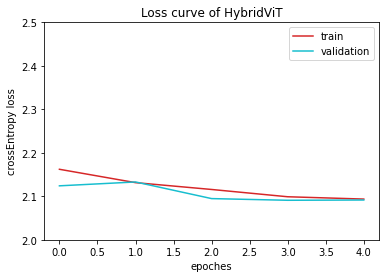

In [ ]:
plot_loss_curve(loss_record, title='HybridViT')

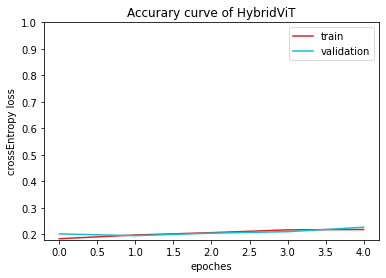

In [ ]:
plot_acc_curve(acc_record, title='HybridViT')

In [ ]:
def test(model, model_name, test_loader):
    correct = 0
    correct_fgm = 0
    correct_pgd = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        images_fgm = fast_gradient_method(model, images, 0.3, np.inf)
        images_pgd = projected_gradient_descent(model, images, 0.3, 0.01, 40, np.inf)
        # calculate outputs by running images through the network
        outputs = model(images)
        outputs_fgm = model(images_fgm)
        outputs_pgd = model(images_pgd)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        _, predicted_fgm = torch.max(outputs_fgm.data, 1)
        _, predicted_pgd = torch.max(outputs_pgd.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        correct_fgm += (predicted_fgm == labels).sum().item()
        correct_pgd += (predicted_pgd == labels).sum().item()

    print('Accuracy of the %s on the 10000 test images: %d %%' % (model_name,
        100 * correct / total))
    print('Accuracy of the %s on the 10000 FGM adversarial images: %d %%' % (model_name,
        100 * correct / total))
    print('Accuracy of the %s on the 10000 PFD adversarial images: %d %%' % (model_name,
        100 * correct / total))

In [ ]:
test(model, 'HybridViT', test_loader)

Accuracy of the HybridViT on the 10000 test images: 22 %
Accuracy of the HybridViT on the 10000 FGM adversarial images: 22 %
Accuracy of the HybridViT on the 10000 PFD adversarial images: 22 %


In [ ]:
PATH = './HybridViT.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
#model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 2. Experienment 1: MobileNet-v2

In [ ]:
from torchvision.models import mobilenet_v2

In [ ]:
class PretrainedMobileNet(nn.Module):
    def __init__(self):
        super(PretrainedMobileNet, self).__init__()
        layers = list(mobilenet_v2(pretrained=True).children())[:-1] #all layer expect last layer
        self.preHead = nn.Sequential(*layers)
        self.fc = 
        
    def forward(self, inp):
        # inp: (batch_size, 3, 224, 224)

        out = self.feature_extractor(inp)

        # out: (batch_size, 64, 56, 56)
        return out

mobileNet = mobilenet_v2(num_classes=10).to(device)

In [ ]:
macs, params = get_model_complexity_info(mobileNet, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.0 GMac
Number of parameters:           1.53 M  


In [ ]:
mobilenet_loss_record = {'train': [], 'validation': []} 
mobilenet_acc_record = {'train': [], 'validation': []} 

In [ ]:
mobilenet_opt = torch.optim.Adam(mobilenet.parameters(), lr=lr)
mobilenet_epochs = epochs

In [ ]:
train(epochs, mobileNet, train_loader, valid_loader, mobilenet_loss_record, mobilenet_acc_record, criterion, mobilenet_opt)

current lr = 0.000300



Epoch : 1 - loss : 2.3349 - acc: 0.1002 - val_loss : 2.3324 - val_acc: 0.0961

current lr = 0.000300



Epoch : 2 - loss : 2.3324 - acc: 0.1032 - val_loss : 2.3327 - val_acc: 0.0934

current lr = 0.000300



Epoch : 3 - loss : 2.3352 - acc: 0.0991 - val_loss : 2.3290 - val_acc: 0.0947

current lr = 0.000300



Epoch : 4 - loss : 2.3328 - acc: 0.1017 - val_loss : 2.3304 - val_acc: 0.1048

current lr = 0.000300



Epoch : 5 - loss : 2.3337 - acc: 0.1010 - val_loss : 2.3308 - val_acc: 0.1034



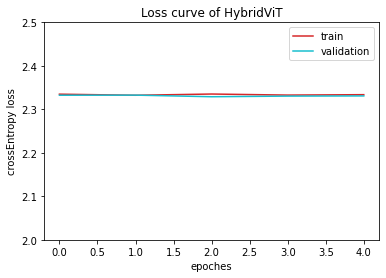

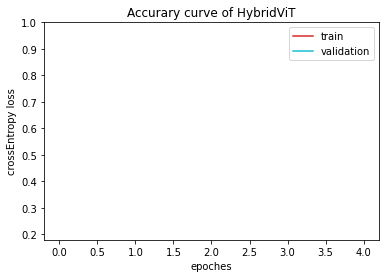

In [ ]:
plot_loss_curve(mobilenet_loss_record, title='HybridViT')
plot_acc_curve(mobilenet_acc_record, title='HybridViT')

In [ ]:
test(mobileNet,'MobileNet_v2', test_loader)

SyntaxError: ignored

comparison

In [ ]:
def loss_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.ylim(0,5)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

def acc_comparison_of_two(record1, record2, model_name_1, model_name_2):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.ylim(0,1)
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('accuracy comparison of %s and %s' % (model_name_1, model_name_2))
    plt.legend()
    plt.show()

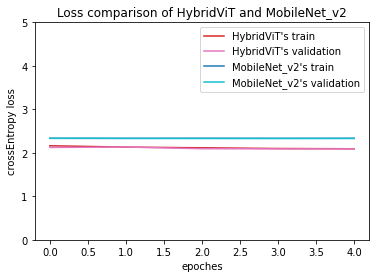

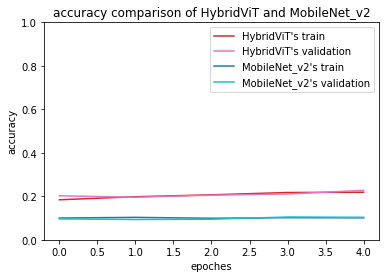

In [ ]:
loss_comparison_of_two(loss_record, mobilenet_loss_record, 'HybridViT', 'MobileNet_v2')
acc_comparison_of_two(acc_record, mobilenet_acc_record, 'HybridViT', 'MobileNet_v2')

In [ ]:
PATH = './mobilenet.pth'
torch.save(mobilenet.state_dict(), PATH)

## 3. experiment 2: model with similar FLOPs

In [ ]:
resnet = resnet101(num_classes=10)

In [ ]:
macs, params = get_model_complexity_info(resnet, (3, 32, 32), as_strings=True,
                                        print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.16 GMac
Number of parameters:           42.52 M 


In [ ]:
resnet_loss_record = {'train': [], 'validation': []} 
resnet_acc_record = {'train': [], 'validation': []} 

In [ ]:
resnet_opt = torch.optim.Adam(resnet.parameters(), lr=lr)
resnet_epochs=epochs

In [ ]:
train(resnet_epochs, resnet, train_loader, valid_loader, resnet_loss_record, resnet_acc_record, criterion, resnet_opt)

In [ ]:
test(resnet, 'ResNet152',test_loader)

In [ ]:
loss_comparison_of_two(loss_record, resnet_loss_record)
acc_comparison_of_two(acc_record, resnet_acc_record)

In [ ]:
def loss_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))

    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:yellow', label=model_name_3+'\'s validation')
    plt.ylim(0.5,1.5)
    plt.xlabel('epoches')
    plt.ylabel('crossEntropy loss')
    plt.title('Loss curve of {}'.format(title))
    plt.legend()
    plt.show()

def acc_comparison_of_three(record1, record2, record3, model_name_1, model_name_2, model_name_3):
    total_steps = len(record1['train'])
    x_1 = range(total_steps)
    x_2=range(len(record2['train']))
    x_3=range(len(record3['train']))
    plt.figure(figsize=[6, 4])
    plt.plot(x_1, record1['train'], c='tab:red', label=model_name_1+'\'s train')
    plt.plot(x_1, record1['validation'], c='tab:pink', label=model_name_1+'\'s validation')
    plt.plot(x_2, record2['train'], c='tab:blue', label=model_name_2+'\'s train')
    plt.plot(x_2, record2['validation'], c='tab:cyan', label=model_name_2+'\'s validation')
    plt.plot(x_3, record3['train'], c='tab:green', label=model_name_3+'\'s train')
    plt.plot(x_3, record3['validation'], c='tab:yellow', label=model_name_3+'\'s validation')
    plt.ylim(0.5,1.5)
    plt.xlabel('epoches')
    plt.ylabel('accuracy')
    plt.title('acc curve of {}'.format(title))
    plt.legend()
    plt.show()

In [ ]:
loss_comparison_of_three(loss_record, mobilenet_loss_record, resnet_loss_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
acc_comparison_of_three(acc_record, mobilenet_acc_record, resnet_acc_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
PATH = './resnet.pth'
torch.save(resnet.state_dict(), PATH)

## 4. experiment 3. model robust

In [ ]:
adv_epochs=50
adv_mobilenet_epochs=50
adv_resnet_epochs=50

In [ ]:
adv_loss_record={'train': [], 'validation': []} 
adv_acc_record={'train': [], 'validation': []} 
adv_mobilenet_loss_record={'train': [], 'validation': []} 
adv_mobilenet_acc_record={'train': [], 'validation': []} 
adv_resnet_loss_record={'train': [], 'validation': []} 
adv_resnet_acc_record={'train': [], 'validation': []} 

In [ ]:
train(adv_epochs, model, train_loader, valid_loader, adv_loss_record, adv_acc_record, criterion, optimizer, adv_train=True)
train(adv_mobilenet_epochs, mobilenet, train_loader, valid_loader, adv_mobilenet_loss_record, adv_mobilenet_acc_record, criterion, mobilenet_optimizer,adv_train=True)
train(adv_resnet_epochs, resnet, train_loader, valid_loader, adv_resnet_loss_record, adv_resnet_acc_record, criterion, resnet_optimizer,adv_train=True)

In [ ]:
loss_comparison_of_three(adv_loss_record, adv_mobilenet_loss_record, adv_resnet_loss_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
acc_comparison_of_three(adv_acc_record, adv_mobilenet_acc_record, adv_resnet_acc_record,'HybridViT','MobileNet_v2','ResNet152')

In [ ]:
test(model, 'robust HybridViT', test_loader)
test(mobileNet, ,'robust MobileNet_v2', test_loader)
test(resnet, 'ResNet152', test_loader)

In [ ]:
PATH = './adv_HybridViT.pth'
torch.save(model.state_dict(), PATH)
PATH = './adv_Mobilenet.pth'
torch.save(mobilenet.state_dict(), PATH)
PATH = './adv_resnet.pth'
torch.save(resnet.state_dict(), PATH)